In [54]:
import yaml
import sys
from pprint import pprint
import argparse
import os, glob, re
import numpy as np
import pandas as pd
import networkx as nx
from fnmatch import fnmatch
# plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [55]:
def normalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [56]:
metric = 'weighted_access_size'
metric_ = metric + ' (sum)'

filtered_file_ext = ['fits', 'vcf', 'txt', 'gz', 'lht', 'out', 'stf']


In [57]:
def printmd(string):
    display(Markdown(string))

In [58]:
def convert2Dict(dlist, id_name):
    return {x[id_name]: x for x in dlist}

def import_yaml(fname):
    with open(fname) as f:
        return yaml.safe_load(f)

In [59]:
class Conversion(object):

    data = None
    job_dependency = None
    tasks = None
    cmds = None
    files = None

    def user_input(self):
        parser = argparse.ArgumentParser('Pegasus DAX Parser')
        parser.add_argument('-w', '--workflow_yml')
        parser.add_argument('-r', '--replica_yml')
        parser.add_argument('-t', '--transformation_yml')
        parser.add_argument('-p', '--radical_pst_yml', help='output yaml filename')
        parser.add_argument('-o', '--output', help='shell script output')
        args = parser.parse_args()
        self.args = args
        return args


    def import_dax(self):

        data = None
        jdep = None
        tasks = None
        files = None
        cmds = None
        print("import dax ...")

        if self.args.workflow_yml:
            data = import_yaml(self.args.workflow_yml)
            data = data['adag']
            jdep = data['jobDependencies']

            if 'executable' in data:
#                 print(data['executable'])
                tasks = convert2Dict(data['executable'], 'name')
#                 print(tasks)
            if 'job' in data:
#                 print(data['job'])
                cmds = convert2Dict(data['job'], 'id')
#                 print(cmds)
            if 'file' in data:
                files = convert2Dict(data['file'], 'name')
#                 print(files)
        if self.args.replica_yml:
            repl = import_yaml(self.args.replica_yml)
            files = convert2Dict(repl['replicas'], 'lfn')
        if self.args.transformation_yml:
            trans = import_yaml(self.args.transformation_yml)
            tasks = convert2Dict(trans['transformations'], 'name')

        self.data = data
        self.job_dependency = jdep
        self.tasks = tasks
        self.cmds = cmds
        self.files = files


    def get_jdep(self):
        dict_dep = {}

        for i in self.job_dependency:
            dict_dep[i['id']] = i['children']

        ordered = {}
        for pjob_id, child_ids in dict_dep.items():
            if pjob_id not in ordered:
               ordered[pjob_id] = 1
            for cjob_id in child_ids:
                if cjob_id not in ordered:
                   ordered[cjob_id] = ordered[pjob_id] + 1
                else:
                   ordered[cjob_id] = max(ordered[pjob_id] + 1, ordered[cjob_id])
        self.ordered = ordered
        self.ordered_by_val = {k: v for k, v in sorted(ordered.items(), key=lambda item: item[1])}


    def get_cmd(self, cid):
        cname = self.cmds[cid]['name']
        #     {'name': 'mConvert', 'sites': [{'name': 'local', 'pfn':
        #     '/files0/oddite/leeh736/Montage/bin/mConvert', 'type': 'stageable'}],
        #     'profiles': {'condor': {'request_memory': '1 GB'}, 'env': {'PATH':
        #     '/usr/bin:/bin:.'}}}
#         print(cname)
        t_path = self.tasks[cname]['pfn']['url']
#         print(t_path)
        return t_path


    def get_arguments(self, cid):
        return self.cmds[cid]['argument']


    def get_data(self, cid):

        inputs = []
        outputs = []
        pre_exec = []

        flist = self.cmds[cid]['uses']
        # uses: 
        # - lfn: pposs2ukstu_blue_001_002_area.fits
        #   type: output
        #   stageOut: false
        #   registerReplica: true
        # - lfn: poss2ukstu_blue_001_002.fits
        #   type: input
#         print(flist)
        for v in flist:
            fname = v['name']
            ftype = v['link']
            # - lfn: region-oversized.hdr
            #   pfns:
            #   - site: local
            #     pfn: file:///files0/oddite/leeh736/montage-workflow-v3/data/region-oversized.hdr
            if fname in self.files:
                fobj = self.files[fname]
                flocation = fobj['pfn']['url']
                fpath = fobj['pfn']['url']
                if flocation == "local":
                    # local copy to cwd
                    if fpath[:7] == "file://":
                        sp = 7
                    else:
                        sp = 0
                    cmd = ["/bin/cp", fpath[sp:], "./"] # '7:', removing the `file://` protocol by indexing counts
                else: # ipac
                    # remote download to cwd
                    cmd = ["/bin/curl", "-o", fname, f"'{fpath}'"]
                pre_exec.append(cmd)
            if ftype == "output":
                outputs.append(fname)
#                 if v['registerReplica']:
#                     self.files[fname] = {'pfns': [{'site': 'local', 'pfn': f'file://${cid}/{fname}'}]}
            else:
                inputs.append(fname)
        return {'inputs': inputs,
                'outputs': outputs,
                'pre_exec': pre_exec}


    def retrieve_cmd_info(self, cid):
        t_exec = self.get_cmd(cid)
        args = self.get_arguments(cid)
        tmp = self.get_data(cid)
        cname = self.cmds[cid]['name']
        return {'exec': t_exec, 'args': args, 'inputs': tmp['inputs'], 'outputs':
                tmp['outputs'], 'pre_exec': tmp['pre_exec'], 'tname': cname}


    def update_id_map_to_pst(self, t_info, m_info):
        pre_exec = t_info['pre_exec']
        for cmd in pre_exec:
            idx = 0
            for element in cmd:
                if element[0] == "$":
                    idname, rest = element.split("/",1)
                    tmp = m_info[idname[1:]]
                    cmd[idx] = "%s/%s" % (tmp, rest)
                idx += 1

    def convert_to_pst(self):
        pst = {}
        t_cnt = 0
        id_map_to_pst = {}
        for k, v in self.ordered_by_val.items():
            t_info = self.retrieve_cmd_info(k)
            s_name = 'stage_%s' % v
            t_name = 'task_%s' % t_cnt
            id_map_to_pst[k] = f'$pipeline_0_{s_name}_{t_name}'
            self.update_id_map_to_pst(t_info, id_map_to_pst)
            task = { t_name : t_info }
            if s_name in pst:
                pst[s_name].append(task)
            else:
                pst[s_name] = [task]
            t_cnt += 1

        pprint(pst, indent=4)
        self.pst = pst

    def save_pst_yml(self):
        outfname = self.args.radical_pst_yml
        if outfname:
            with open(outfname, 'w') as outfile:
                yaml.dump(self.pst, outfile, default_flow_style=False)

    def save_shell_script(self):
        outfname = self.args.output
        if outfname:
            with open(outfname, 'w') as outfile:
                lines = []
                for k, v in self.ordered_by_val.items():
                    t_info = self.retrieve_cmd_info(k)
                    for l in t_info['pre_exec']:
                        outfile.write(" ".join(l) + "\n")
                    line = "%s %s " % (t_info['exec'], " ".join(t_info['args']))
                    outfile.write(f"{line}\n")


In [60]:
class args():
    workflow_yml = None
    replica_yml = None
    transformation_yml = None

args = args()
args.workflow_yml = 'seismology_cut.yml'

In [61]:
obj = Conversion()

In [62]:
obj.args = args
obj.import_dax()
obj.get_jdep()

import dax ...


In [63]:
# loading tazer stat files into pandas dataframe
def stat_to_df(fname):

    df = pd.read_csv(fname, sep=' ', names=['block_idx', 'frequency', 'access_size'], skiprows=1)
    return df

def read_tazer_stats(dpath):
    print("Test test...")

    agg_sum = {'frequency':'sum', 'access_size':'sum', 'weighted_access_size': 'sum'}
    agg_avg = {'frequency':'mean', 'access_size':'mean', 'weighted_access_size': 'mean'}
    agg_sum_rename = {'frequency': 'frequency (sum)', 
                      'access_size': 'access_size (sum)', 
                      'weighted_access_size': 'weighted_access_size (sum)'}
    agg_avg_rename = {'frequency': 'frequency (avg)', 
                      'access_size': 'access_size (avg)',
                      'weighted_access_size': 'weighted_access_size (avg)'}

    df_all = {}
#     print(dpath)

    for fpath in glob.glob(dpath + "/*/*_stat"):

        # ignore trace stats but for r/w stat
#         print(fpath)
        if fpath[-10:] == "trace_stat":
            continue
#         print(fpath)
        df = stat_to_df(fpath)
        if df.empty is True:
            continue
            
        df['weighted_access_size'] = df['frequency'] * df['access_size']
        task_name = os.path.basename(os.path.dirname(fpath))
        stat_filename = os.path.basename(fpath)
        series = df.agg(agg_sum)
        df_sum = pd.DataFrame(series).transpose().rename(columns=agg_sum_rename)
        series = df.agg(agg_avg)
        df_avg = pd.DataFrame(series).transpose().rename(columns=agg_avg_rename)
        df = pd.concat([df_sum, df_avg], axis=1)
        if task_name in df_all:
            if stat_filename in df_all[task_name]:
                print(fname, "==duplicate==")
            df_all[task_name][stat_filename] = df
        else:
            df_all[task_name] = {stat_filename: df}
            
    return df_all

In [64]:
def get_graph(data, df):
    print("Building a graph with this metric:", metric_)
#     print(df)
    _pos = (0, -1)
    G = nx.DiGraph()
    prev_v = 1
    cnt = 0
    for k, v in data.ordered_by_val.items():
#         print(k, v)
        if prev_v == v:
            cnt += 1
        else:
            cnt = 0
        if cnt > 10000:
            prev_v = v
            continue
        t_info = data.retrieve_cmd_info(k)
        tname = t_info['tname']+'_'+k
        tnodename = "%s (%s)" % (tname, k)
        if prev_v == v:
            _pos = (_pos[0], _pos[1] + 4)
        else:
            _pos = (v + 5, 0)
        G.add_node(tnodename, ntype='task', pos=_pos)
        prev_v = v
        __pos = _pos
        for ftype in ['inputs', 'outputs']:

            bnames = [x for x in t_info[ftype] if x.split('.')[-1] in filtered_file_ext]
            
            if ftype == 'inputs':
                __pos = (_pos[0] - 2.5, __pos[1])
            else:
                __pos = (_pos[0] + 2.5, __pos[1])
            
            for bname in bnames:
                sname = bname + "_r_stat" if ftype == 'inputs' else bname + "_w_stat"
                if sname not in df[tname]:
                    print(sname , "==missing==")
                    continue
                stat = df[tname][sname]
                frequency = stat[metric_][0]
                frequency_sum = stat['frequency (sum)'][0]
                if G.has_node(bname) is False:
                    G.add_node(bname, pos=__pos)
                    __pos = (__pos[0], __pos[1] + 20)
                if ftype == 'inputs':
                    G.add_edge(bname, tnodename, value=frequency, width=8, frequency_sum=frequency_sum)
                else:
                    G.add_edge(tnodename, bname, value=frequency, width=8, frequency_sum=frequency_sum)
        _pos = (_pos[0], __pos[1])
        #_pos = (_pos[0] + 1, 0) 
    return G, _pos

In [65]:
df_all = read_tazer_stats("tazer_stat")
# print(df_all)
G, _pos = get_graph(obj, df_all)

Test test...
Building a graph with this metric: weighted_access_size (sum)


In [66]:
print ("node count:%s" % len(G.nodes()))
print ("edge count:%s" % len(G.edges()))

node count:82
edge count:81


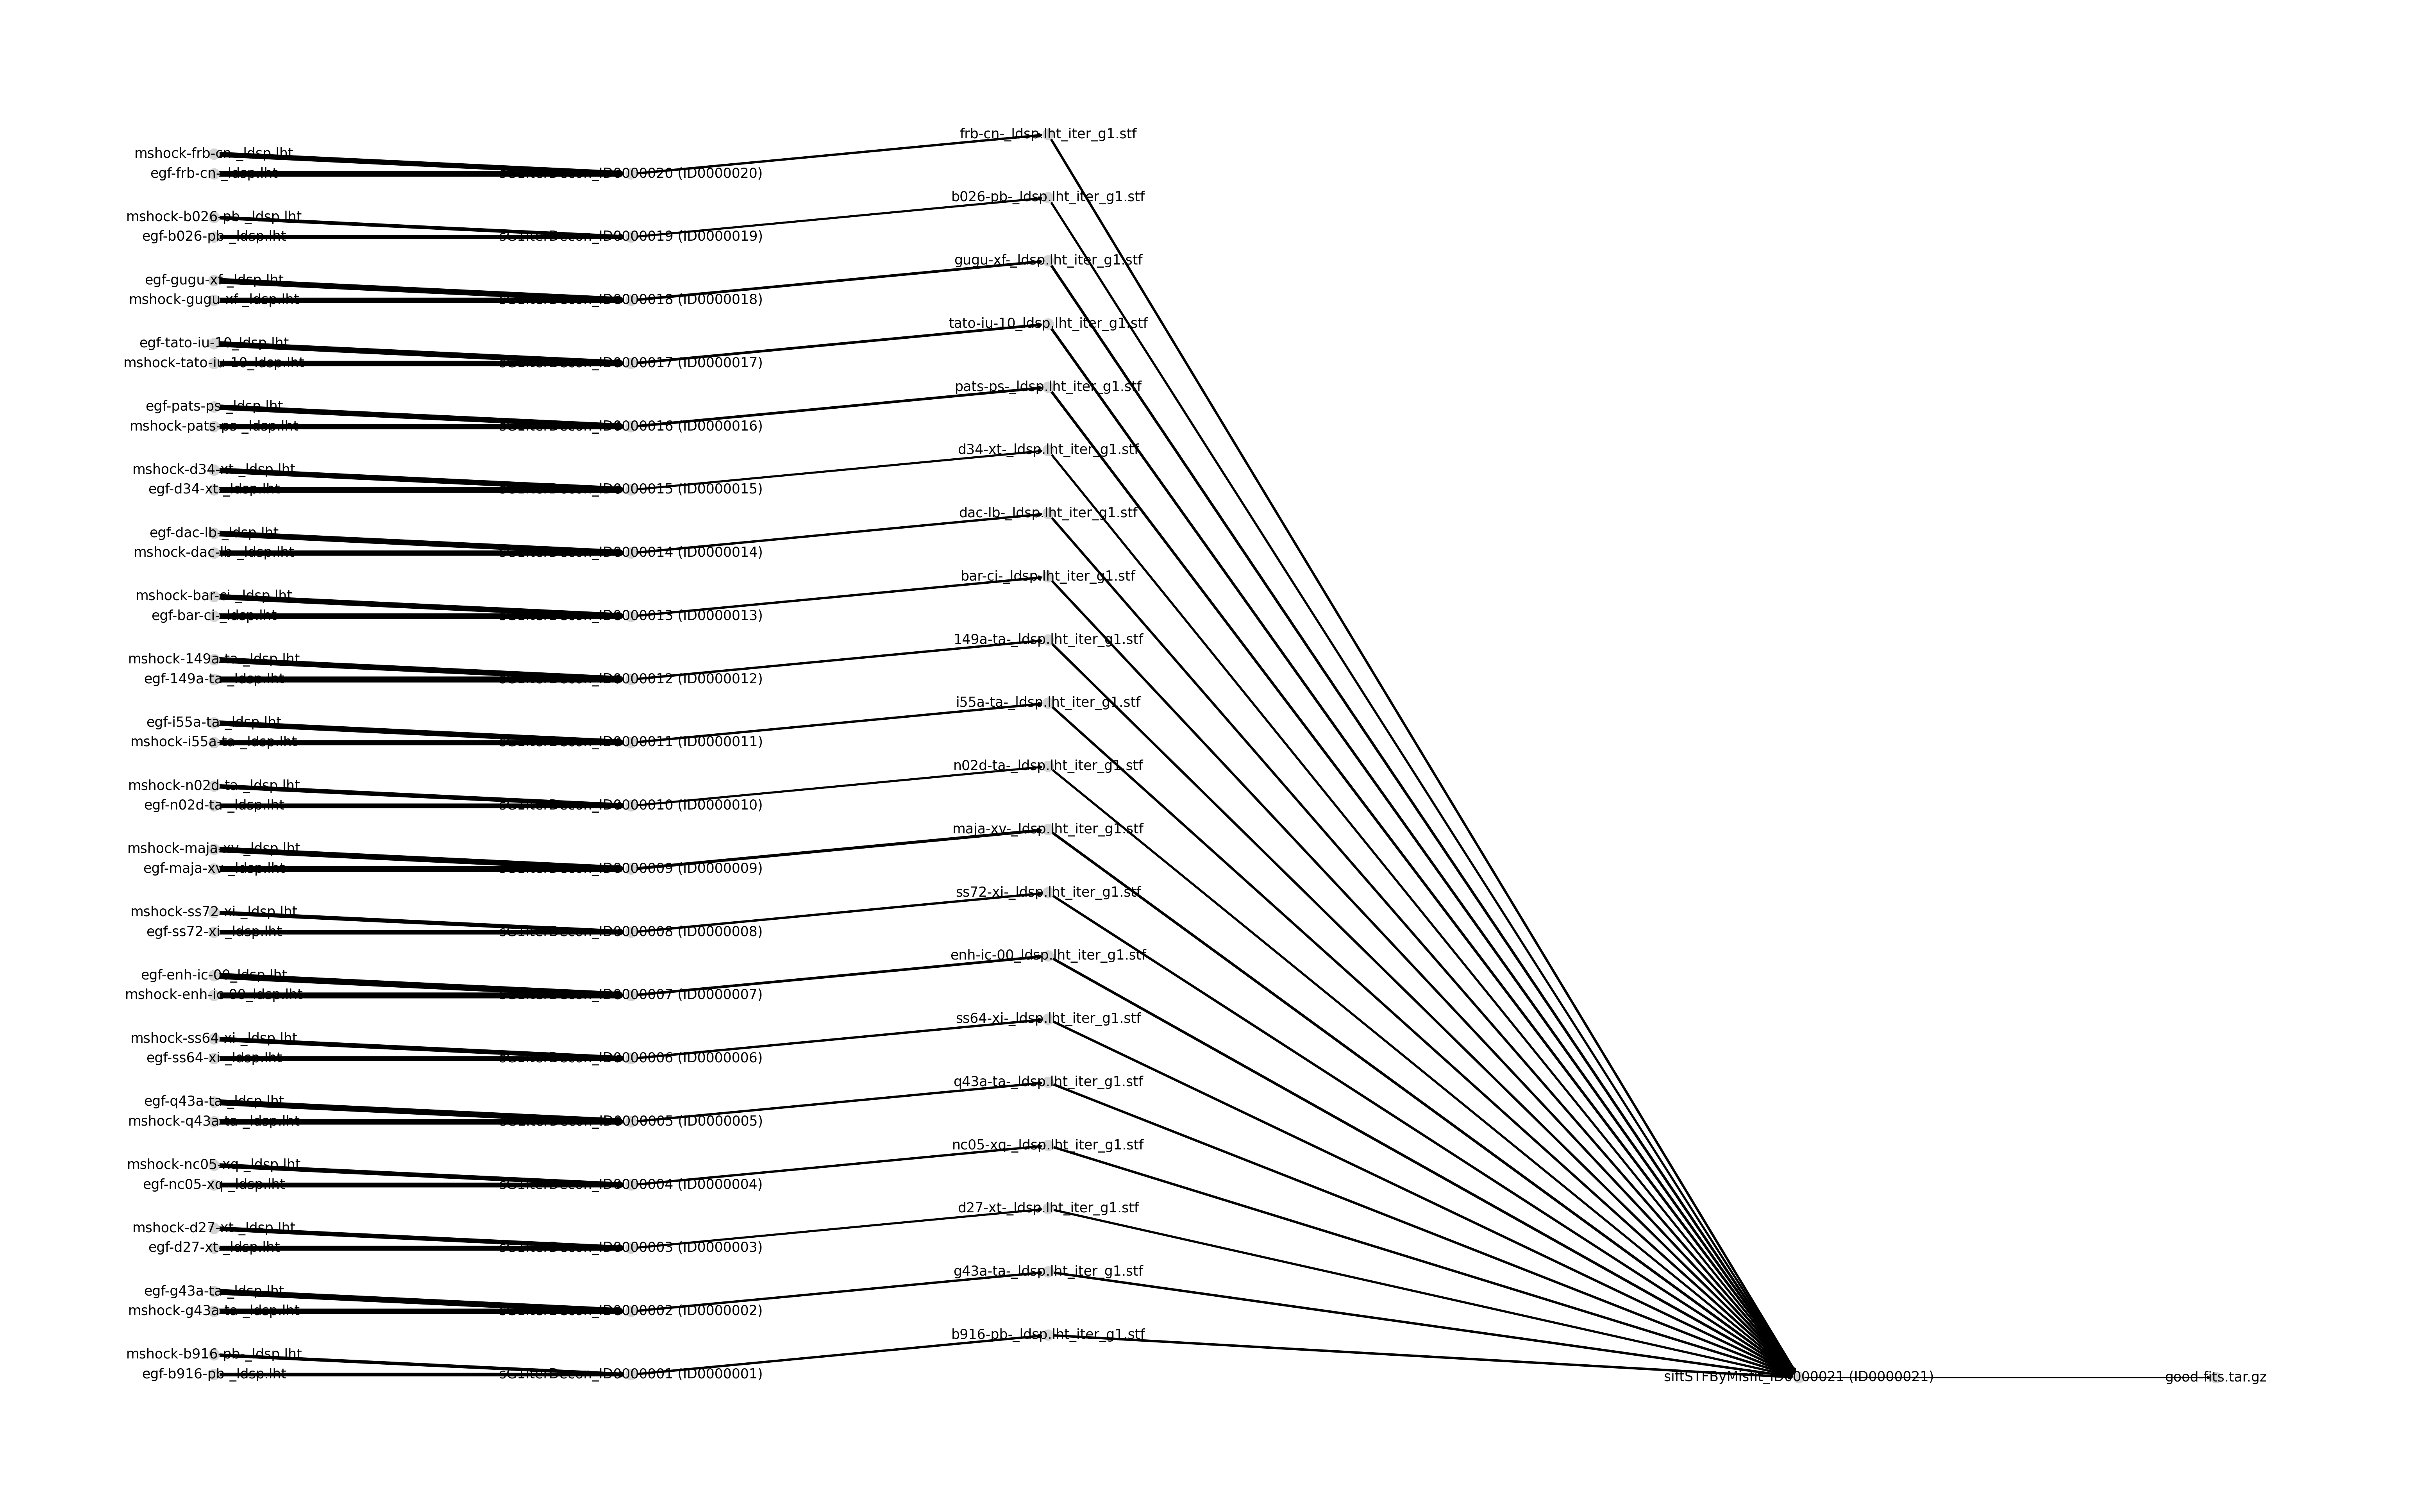

In [67]:
B = G
pos = {k: np.asarray(v) for k, v in B.nodes(data="pos")}
# print(pos)
node_colors = ["skyblue" if u == "mProject" else "lightgray" for u in B.nodes]
plt.figure(figsize=(80, 50))
nx.draw_networkx_nodes(B, pos=pos, node_size=400, node_color=node_colors)
nx.draw_networkx_labels(B, pos=pos, font_size=25)
w=list(nx.get_edge_attributes(G, 'value').values())
wlog=np.log10(w)
nx.draw_networkx_edges(B, pos=pos, width=wlog)
#plt.title(f"Max Flow = {R.graph['flow_value']}", size=12)
plt.axis("off")
plt.show()

In [68]:
def table_for_producer_consumer(G, unit="byte"):
    
    is_round = True
    
    column1 = []
    column2 = []
    #column3 = []
    #column4 = []
    if unit.lower() == "gb":
        unit_size = 10e8
    elif unit.lower() == "mb":
        unit_size = 10e5
    elif unit.lower() == "kb":
        unit_size = 10e2
    else:
        unit = "byte"
        unit_size = 10e-1
        
    for node in G.nodes():
        # skip if not a file vertex where a task (producer) - a file and a task (consumer) could form
        ival = 0
        oval = 0
        if is_node_type(node, "task"):
            continue
            
        if len(node.split('.')) <= 1:
            continue
        for iedge in G.in_edges(node):
            for oedge in G.out_edges(node):
                ival = G.edges[iedge]['value']
                oval = G.edges[oedge]['value']
                column1.append((iedge, oedge))
                column2.append(round((ival + oval) / unit_size, 2))
#                 print(iedge, oedge, ival, oval, unit_size)
                #column3.append(ival)
                #column4.append(oval)
    return pd.DataFrame({'task (p) - file, file - task (c) edges':column1, 
                         f'access_size ({unit})': column2})
    
def is_node_type(node_name, ntype_expected):
    
    if len(node_name.split('.')) <= 1:
        ntype_found = "task"
    else:
        ntype_found = "file"
    return ntype_found == ntype_expected

def _table_for_metric(G, element_type, edges_to_collect="out", unit="byte"):
    
    is_round = True
    
    if element_type == "producer-consumer":
        node_selection = 'file'
    elif element_type == "file":
        node_selection = 'file'
    elif element_type == "task":
        node_selection = 'task'
    
    col1 = []
    col2 = []
    #col3 = []
    #col4 = []
    if unit.lower() == "gb":
        unit_size = 10e8
    elif unit.lower() == "mb":
        unit_size = 10e5
    elif unit.lower() == "kb":
        unit_size = 10e2
    else:
        unit = "byte"
        unit_size = 10e-1
        
    for node in G.nodes():
        # skip if not a file vertex where a task (producer) - a file and a task (consumer) could form
        if not is_node_type(node, node_selection):
            continue
        
        if element_type == "file" or element_type == "task":
            val = 0
            if edges_to_collect == "out" or edges_to_collect == "both":
                for edge in G.out_edges(node):
                    val += G.edges[edge]['value']
            if edges_to_collect == "in" or edges_to_collect == "both":
                for edge in G.in_edges(node):
                    val += G.edges[edge]['value']
            col1.append(node)
            col2.append(round(val / unit_size, 2) if is_round else val)
        else: # "producer-consumer"
            if is_node_type(node, "task"):
                continue
            for iedge in G.in_edges(node):
                for oedge in G.out_edges(node):
                    ival = G.edges[iedge]['value']
                    oval = G.edges[oedge]['value']
                    col1.append((iedge, oedge))
                    col2.append(round((ival + oval) / unit_size, 2)  if is_round else val)
                    #col3.append(ival)
                    #col4.append(oval)
    return col1, col2
                

def table_for_file_node(G, edges_to_collect="out", unit="byte"):
    node_type = 'file'
    col1, col2 = _table_for_metric(G, node_type, edges_to_collect=edges_to_collect, unit=unit)
    return pd.DataFrame({f'node ({node_type})':col1, 
                         f'access_size ({unit})': col2})


def table_for_task_node(G, edges_to_collect="in", unit="byte"):
    node_type = 'task'
    col1, col2 = _table_for_metric(G, node_type, edges_to_collect=edges_to_collect, unit=unit)
    return pd.DataFrame({f'node ({node_type})':col1, 
                         f'access_size ({unit})': col2})    

In [69]:
def table_for_edges(G, unit="byte"):
    col1 = []
    col2 = []
    is_round = True
    if unit.lower() == "gb":
        unit_size = 10e8
    elif unit.lower() == "mb":
        unit_size = 10e5
    elif unit.lower() == "kb":
        unit_size = 10e2
    else:
        unit = "byte"
        unit_size = 10e-1
        
    for node1,node2,value in G.edges(data=True):
        col1.append((node1, node2))
        val = value['value']
        col2.append(round(val / unit_size, 2)  if is_round else val)
    
    node_type = 'edge'
    return pd.DataFrame({f'node ({node_type})':col1, 
                         f'access_size ({unit})': col2})
        
df_e = table_for_edges(G, "GB")

In [70]:
his_unit = "KB"
df_pc = table_for_producer_consumer(G, unit=his_unit) 

In [71]:
my_unit = "GB"
df_file = table_for_file_node(G, unit=my_unit)
# print(df_file)

In [72]:
df_task = table_for_task_node(G, unit=my_unit)
# print(df_task)

In [73]:
df_e.sort_values(by=f'access_size ({my_unit})', ascending=False)

,node (edge),access_size (GB)
26,"(egf-enh-ic-00_ldsp.lht, sG1IterDecon_ID0000007 (ID0000007))",313.38
33,"(egf-maja-xv-_ldsp.lht, sG1IterDecon_ID0000009 (ID0000009))",112.46
45,"(egf-149a-ta-_ldsp.lht, sG1IterDecon_ID0000012 (ID0000012))",110.50
18,"(egf-q43a-ta-_ldsp.lht, sG1IterDecon_ID0000005 (ID0000005))",78.73
25,"(mshock-enh-ic-00_ldsp.lht, sG1IterDecon_ID0000007 (ID0000007))",78.70
6,"(egf-g43a-ta-_ldsp.lht, sG1IterDecon_ID0000002 (ID0000002))",67.58
49,"(egf-bar-ci-_ldsp.lht, sG1IterDecon_ID0000013 (ID0000013))",48.27
57,"(egf-d34-xt-_ldsp.lht, sG1IterDecon_ID0000015 (ID0000015))",41.88
70,"(egf-gugu-xf-_ldsp.lht, sG1IterDecon_ID0000018 (ID0000018))",32.69
54,"(egf-dac-lb-_ldsp.lht, sG1IterDecon_ID0000014 (ID0000014))",30.59


In [74]:
df_file.sort_values(by=f'access_size ({my_unit})', ascending=False)

,node (file),access_size (GB)
19,egf-enh-ic-00_ldsp.lht,313.38
24,egf-maja-xv-_ldsp.lht,112.46
33,egf-149a-ta-_ldsp.lht,110.50
13,egf-q43a-ta-_ldsp.lht,78.73
18,mshock-enh-ic-00_ldsp.lht,78.70
4,egf-g43a-ta-_ldsp.lht,67.58
36,egf-bar-ci-_ldsp.lht,48.27
42,egf-d34-xt-_ldsp.lht,41.88
52,egf-gugu-xf-_ldsp.lht,32.69
40,egf-dac-lb-_ldsp.lht,30.59


In [75]:
df_task.sort_values(by=f'access_size ({my_unit})', ascending=False)

,node (task),access_size (GB)
6,sG1IterDecon_ID0000007 (ID0000007),392.08
8,sG1IterDecon_ID0000009 (ID0000009),140.79
11,sG1IterDecon_ID0000012 (ID0000012),138.06
4,sG1IterDecon_ID0000005 (ID0000005),98.39
1,sG1IterDecon_ID0000002 (ID0000002),84.46
12,sG1IterDecon_ID0000013 (ID0000013),60.32
14,sG1IterDecon_ID0000015 (ID0000015),52.32
17,sG1IterDecon_ID0000018 (ID0000018),40.94
13,sG1IterDecon_ID0000014 (ID0000014),38.24
16,sG1IterDecon_ID0000017 (ID0000017),37.97


In [76]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

df_pc.sort_values(by=f'access_size ({his_unit})', ascending=False)

,"task (p) - file, file - task (c) edges",access_size (KB)
8,"((sG1IterDecon_ID0000009 (ID0000009), maja-xv-_ldsp.lht_iter_g1.stf), (maja-xv-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",338.40
17,"((sG1IterDecon_ID0000018 (ID0000018), gugu-xf-_ldsp.lht_iter_g1.stf), (gugu-xf-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
16,"((sG1IterDecon_ID0000017 (ID0000017), tato-iu-10_ldsp.lht_iter_g1.stf), (tato-iu-10_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
15,"((sG1IterDecon_ID0000016 (ID0000016), pats-ps-_ldsp.lht_iter_g1.stf), (pats-ps-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
6,"((sG1IterDecon_ID0000007 (ID0000007), enh-ic-00_ldsp.lht_iter_g1.stf), (enh-ic-00_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
0,"((sG1IterDecon_ID0000001 (ID0000001), b916-pb-_ldsp.lht_iter_g1.stf), (b916-pb-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
1,"((sG1IterDecon_ID0000002 (ID0000002), g43a-ta-_ldsp.lht_iter_g1.stf), (g43a-ta-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
13,"((sG1IterDecon_ID0000014 (ID0000014), dac-lb-_ldsp.lht_iter_g1.stf), (dac-lb-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
12,"((sG1IterDecon_ID0000013 (ID0000013), bar-ci-_ldsp.lht_iter_g1.stf), (bar-ci-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
11,"((sG1IterDecon_ID0000012 (ID0000012), 149a-ta-_ldsp.lht_iter_g1.stf), (149a-ta-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28


In [77]:
print ("access_size avg: {:.2f} KB".format( np.mean(df_pc[f'access_size ({his_unit})']) ))

access_size avg: 74.75 KB


In [78]:
def graph_by_table_with_top_x(G, df, metric_name, edges_to_collect="both", count=10, ascending=False):
    new_G = nx.DiGraph()
    t = df.sort_values(by=[metric_name], ascending=ascending)
    cnt = 0
    for idx, row in t.iterrows():
        if(len(row[0]) > 1 and isinstance(row[0][0], tuple)):
#             print("test1")
            iedge, oedge = row[0][0], row[0][1]
#             print(G.edges[iedge])
            ival = G.edges[iedge]['value']
            new_G.add_edges_from([iedge], value=1) #new_G.add_edges_from([iedge], value=ival)
            oval = G.edges[oedge]['value']
            new_G.add_edges_from([oedge], value=1) #new_G.add_edges_from([oedge], value=oval)
        elif (len(row[0]) > 1 and isinstance(row[0], tuple)):
#             print("test2")
            edge = row[0]
            val = G.edges[edge]['value']
            new_G.add_edges_from([edge], value=1) #new_G.add_edges_from([edge], value=val)
        else:
#             print("test3")
            node_name = row[0]
            if edges_to_collect == "in" or edges_to_collect == "both":
                for edge in G.in_edges(node_name):
                    val = G.edges[edge]['value']
                    new_G.add_edges_from([edge], value=1) #new_G.add_edges_from([edge], value=val)
            if edges_to_collect == "out" or edges_to_collect == "both":
                for edge in G.out_edges(node_name):
                    val = G.edges[edge]['value']
                    new_G.add_edges_from([edge], value=1) #new_G.add_edges_from([edge], value=val)                 
        cnt += 1
        if cnt >= count:
            break
    return new_G

In [79]:
color_map = {"task": "red",
                 "file": "blue",
                 "none": "grey",
                }
def get_nodes_for_sankey(G, color_map=color_map):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[]}

    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        node_type = 'task' if 'ID' in node_name else 'file'
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        if "producer" in color_map and "consumer" in color_map:
            if(node_type == "task" and len(G.in_edges(node_name)) < 1):
                node_type = "producer"
            elif(node_type == "task" and len(G.out_edges(node_name)) < 1):
                node_type = "consumer"
        #sankey
        node_dict_for_sankey['label'].append(node_name)
        node_dict_for_sankey['color'].append(color_map[node_type])
        #node_dict_for_sankey['x'].append(attr['pos'][0]/10.0)
        #node_dict_for_sankey['y'].append(attr['pos'][1]/10.0)
    return node_dict_for_sankey, node_dict_ref

def get_links_for_sankey(G, node_dict_ref, metric='value'):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[]}
    for u, v, attr in G.edges(data=True):
#         print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)
        link_dict_for_sankey['value'].append(attr[metric])
    return link_dict_for_sankey

In [80]:
def selected_graph(node_name, G):
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [81]:
df_pc.sort_values(by=f'access_size ({his_unit})', ascending=False)[0:20]

,"task (p) - file, file - task (c) edges",access_size (KB)
8,"((sG1IterDecon_ID0000009 (ID0000009), maja-xv-_ldsp.lht_iter_g1.stf), (maja-xv-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",338.40
17,"((sG1IterDecon_ID0000018 (ID0000018), gugu-xf-_ldsp.lht_iter_g1.stf), (gugu-xf-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
16,"((sG1IterDecon_ID0000017 (ID0000017), tato-iu-10_ldsp.lht_iter_g1.stf), (tato-iu-10_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
15,"((sG1IterDecon_ID0000016 (ID0000016), pats-ps-_ldsp.lht_iter_g1.stf), (pats-ps-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
6,"((sG1IterDecon_ID0000007 (ID0000007), enh-ic-00_ldsp.lht_iter_g1.stf), (enh-ic-00_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",141.79
0,"((sG1IterDecon_ID0000001 (ID0000001), b916-pb-_ldsp.lht_iter_g1.stf), (b916-pb-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
1,"((sG1IterDecon_ID0000002 (ID0000002), g43a-ta-_ldsp.lht_iter_g1.stf), (g43a-ta-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
13,"((sG1IterDecon_ID0000014 (ID0000014), dac-lb-_ldsp.lht_iter_g1.stf), (dac-lb-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
12,"((sG1IterDecon_ID0000013 (ID0000013), bar-ci-_ldsp.lht_iter_g1.stf), (bar-ci-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28
11,"((sG1IterDecon_ID0000012 (ID0000012), 149a-ta-_ldsp.lht_iter_g1.stf), (149a-ta-_ldsp.lht_iter_g1.stf, siftSTFByMisfit_ID0000021 (ID0000021)))",47.28


In [82]:
# the volume at edges is defined as the traffic going through 
# the edge between a task and a file 
# the sankey diagram with edges
# num_rows_to_select = 35
num_rows_to_select = len(df_e)
e_G = graph_by_table_with_top_x(G, df_e, f'access_size ({my_unit})', count=num_rows_to_select, ascending=False)
color_map_pc = {"task": "red",
                 "file": "blue",
                 "none": "grey"
                }
n_exp_pc, node_ref_exp_pc = get_nodes_for_sankey(e_G, color_map_pc)
l_exp_pc = get_links_for_sankey(e_G, node_ref_exp_pc)

fig = go.Figure(go.Sankey(
            node = n_exp_pc,
            link = l_exp_pc, orientation='h'))
# fig.update_layout(dict1=dict(height=2050, width=3550), title_text="1000genome Sankey Diagram", font_size=20)
# fig.write_image("seismology_workflow_all_edges.png")

printmd(f"**<center>Top ranked Edges ({num_rows_to_select} out of {len(df_e)})**")
fig.show()
print("\033[94mblue: file")
print("\033[91mred: task node")
print("\033[97mgrey: read file i/o")
print(n_exp_pc)

**<center>Top ranked Edges (81 out of 81)**

blue: file
red: task node
grey: read file i/o
{'label': ['egf-enh-ic-00_ldsp.lht', 'sG1IterDecon_ID0000007 (ID0000007)', 'egf-maja-xv-_ldsp.lht', 'sG1IterDecon_ID0000009 (ID0000009)', 'egf-149a-ta-_ldsp.lht', 'sG1IterDecon_ID0000012 (ID0000012)', 'egf-q43a-ta-_ldsp.lht', 'sG1IterDecon_ID0000005 (ID0000005)', 'mshock-enh-ic-00_ldsp.lht', 'egf-g43a-ta-_ldsp.lht', 'sG1IterDecon_ID0000002 (ID0000002)', 'egf-bar-ci-_ldsp.lht', 'sG1IterDecon_ID0000013 (ID0000013)', 'egf-d34-xt-_ldsp.lht', 'sG1IterDecon_ID0000015 (ID0000015)', 'egf-gugu-xf-_ldsp.lht', 'sG1IterDecon_ID0000018 (ID0000018)', 'egf-dac-lb-_ldsp.lht', 'sG1IterDecon_ID0000014 (ID0000014)', 'egf-tato-iu-10_ldsp.lht', 'sG1IterDecon_ID0000017 (ID0000017)', 'mshock-maja-xv-_ldsp.lht', 'mshock-149a-ta-_ldsp.lht', 'mshock-q43a-ta-_ldsp.lht', 'egf-frb-cn-_ldsp.lht', 'sG1IterDecon_ID0000020 (ID0000020)', 'mshock-g43a-ta-_ldsp.lht', 'mshock-bar-ci-_ldsp.lht', 'egf-pats-ps-_ldsp.lht', 'sG1IterDecon_ID0000016 (ID0000016)', 'egf-i55a-ta-_ldsp.l

In [83]:
node_pos=nx.get_node_attributes(G,'pos')
node_pos

{'sG1IterDecon_ID0000001 (ID0000001)': (0, 3),
 'egf-b916-pb-_ldsp.lht': (-2.5, 3),
 'mshock-b916-pb-_ldsp.lht': (-2.5, 23),
 'b916-pb-_ldsp.lht_iter_g1.stf': (2.5, 43),
 'sG1IterDecon_ID0000002 (ID0000002)': (0, 67),
 'mshock-g43a-ta-_ldsp.lht': (-2.5, 67),
 'egf-g43a-ta-_ldsp.lht': (-2.5, 87),
 'g43a-ta-_ldsp.lht_iter_g1.stf': (2.5, 107),
 'sG1IterDecon_ID0000003 (ID0000003)': (0, 131),
 'egf-d27-xt-_ldsp.lht': (-2.5, 131),
 'mshock-d27-xt-_ldsp.lht': (-2.5, 151),
 'd27-xt-_ldsp.lht_iter_g1.stf': (2.5, 171),
 'sG1IterDecon_ID0000004 (ID0000004)': (0, 195),
 'egf-nc05-xq-_ldsp.lht': (-2.5, 195),
 'mshock-nc05-xq-_ldsp.lht': (-2.5, 215),
 'nc05-xq-_ldsp.lht_iter_g1.stf': (2.5, 235),
 'sG1IterDecon_ID0000005 (ID0000005)': (0, 259),
 'mshock-q43a-ta-_ldsp.lht': (-2.5, 259),
 'egf-q43a-ta-_ldsp.lht': (-2.5, 279),
 'q43a-ta-_ldsp.lht_iter_g1.stf': (2.5, 299),
 'sG1IterDecon_ID0000006 (ID0000006)': (0, 323),
 'egf-ss64-xi-_ldsp.lht': (-2.5, 323),
 'mshock-ss64-xi-_ldsp.lht': (-2.5, 343),
 '

In [84]:
node_color_highlighted = 'red'
node_color = 'gray'
def draw_task_relation_graph_with_critical_path(G, cp, pos=None):
    node_color_highlighted = 'red'
    node_color = 'gray'
    edge_color_highlighted = 'red'
    edge_color = 'gray'
    metric = 'weight'
    # set the coordinates of each node
    node_pos=nx.get_node_attributes(G, 'pos') or pos
    # The edge attribute of each arcs are stored in a dictionary
    arc_weight=nx.get_edge_attributes(G,metric)
    colored_edges = list(zip(cp,cp[1:]))
    # If the node is in the shortest path, set it to red, else set it to grey color
    node_col = [node_color if not node in cp else node_color_highlighted for node in G.nodes()]
    # If the edge is in the critical path, else set it to white color
    edge_col = [edge_color if not edge in colored_edges else edge_color_highlighted for edge in G.edges()]
    # Draw the nodes
    nx.draw_networkx(G, node_pos, node_color= node_col, node_size=450)
    # Draw the node labels
    # nx.draw_networkx_labels(G1, node_pos,node_color= node_col)
    # Draw the edges
    nx.draw_networkx_edges(G, node_pos, edge_color= edge_col, style='--')
    # Draw the edge labels
    nx.draw_networkx_edge_labels(G, node_pos, edge_labels=arc_weight)
    # Remove the axis
    plt.axis('off')
    print('task relation graph')
    # Show the plot
    plt.show()
    # description
    print('edge labels: weight')
    print('node in red: critical path')    
cpath = nx.dag_longest_path(G)

In [85]:
num_rows_to_select = len(df_e)
e_G = graph_by_table_with_top_x(G, df_e, f'access_size ({my_unit})', count=num_rows_to_select, ascending=False)
n_exp_pc, node_ref_exp_pc = get_nodes_for_sankey(e_G, color_map_pc)
l_exp_pc = get_links_for_sankey(e_G, node_ref_exp_pc)

for i, name in enumerate(n_exp_pc['label']):
    name=name.replace('ALL.txt', 'ALL')
    name=name.replace('AMR.txt', 'AMR')
    name=name.replace('EUR.txt', 'EUR')
    name=name.replace('GBR.txt', 'GBR')
    name=name.replace('SAS.txt', 'SAS')
    name=name.replace('EAS.txt', 'EAS')
    name=name.replace('AFR.txt', 'AFR')
    name=name.replace('tar.gz', 'tgz')
    m = name.split('_ID')[0]
    n_exp_pc['label'][i] = m
n_exp_pc

{'label': ['egf-enh-ic-00_ldsp.lht',
  'sG1IterDecon',
  'egf-maja-xv-_ldsp.lht',
  'sG1IterDecon',
  'egf-149a-ta-_ldsp.lht',
  'sG1IterDecon',
  'egf-q43a-ta-_ldsp.lht',
  'sG1IterDecon',
  'mshock-enh-ic-00_ldsp.lht',
  'egf-g43a-ta-_ldsp.lht',
  'sG1IterDecon',
  'egf-bar-ci-_ldsp.lht',
  'sG1IterDecon',
  'egf-d34-xt-_ldsp.lht',
  'sG1IterDecon',
  'egf-gugu-xf-_ldsp.lht',
  'sG1IterDecon',
  'egf-dac-lb-_ldsp.lht',
  'sG1IterDecon',
  'egf-tato-iu-10_ldsp.lht',
  'sG1IterDecon',
  'mshock-maja-xv-_ldsp.lht',
  'mshock-149a-ta-_ldsp.lht',
  'mshock-q43a-ta-_ldsp.lht',
  'egf-frb-cn-_ldsp.lht',
  'sG1IterDecon',
  'mshock-g43a-ta-_ldsp.lht',
  'mshock-bar-ci-_ldsp.lht',
  'egf-pats-ps-_ldsp.lht',
  'sG1IterDecon',
  'egf-i55a-ta-_ldsp.lht',
  'sG1IterDecon',
  'mshock-d34-xt-_ldsp.lht',
  'mshock-gugu-xf-_ldsp.lht',
  'mshock-tato-iu-10_ldsp.lht',
  'mshock-dac-lb-_ldsp.lht',
  'mshock-frb-cn-_ldsp.lht',
  'mshock-pats-ps-_ldsp.lht',
  'mshock-i55a-ta-_ldsp.lht',
  'egf-ss64-xi-_ld

In [86]:
import networkx as nx
import matplotlib.pyplot as plt

def node_space(nleaves):
    return 1+int((nleaves-1)/2)

def prepare_caterpillar_tree(G, path):
    nb_leaves = {}
    for node in path:
#        neighbors = set(G.neighbors(node)) #| set(tmp)
        neighbors = set(G.predecessors(node))|set(G.neighbors(node)) #| set(tmp)
        nb_leaves[node] = neighbors - set(path)
    max_leaves = max(len(v) for v in nb_leaves.values())
    space_needed = 1 + sum(node_space(len(v)) for v in nb_leaves.values())
    return nb_leaves, max_leaves, space_needed

def caterpillar_tree_in_graph(G, nb_leaves):
    caterpillar_tree = nx.DiGraph()
    prev = None
    for k, v in nb_leaves.items():
        incoming = set([x for x in G.predecessors(k)])
        outgoing = set([x for x in G.successors(k)])
        #print(k, v, incoming,outgoing)
        for vv in v:
            if vv in incoming:
                caterpillar_tree.add_edge(vv, k)
            else:
                caterpillar_tree.add_edge(k, vv)
                
        #caterpillar_tree.add_edges_from(list(zip([k]*len(v), v)))
        if prev is not None:
            caterpillar_tree.add_edge(prev, k)
        if k in G.nodes and 'ntype' in G.nodes[k] and G.nodes[k]['ntype'] == 'task':
            caterpillar_tree.add_node(k, ntype='task')
        for vv in v:
            if vv in G.nodes and 'ntype' in G.nodes[vv] and G.nodes[vv]['ntype'] == 'task':
                caterpillar_tree.add_node(vv, ntype='task')
        prev = k
    return caterpillar_tree

def draw_caterpillar(G, cpath, pos, options=None, metric = 'value', with_edge_labels=False, fname=None):
    node_color = 'red'
    node_color_highlighted = 'red'#'darkviolet'#'purple'
    node_col_removed = [node_color if not node in cpath else node_color_highlighted for node in G.nodes()]
    if options is None:
        options = {
            "font_size": 9,
            "node_size": 300,
            "node_color": node_col_removed,
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
            "with_labels": False
        }
    ax = plt.gca()
    nx.draw_networkx(G, pos, **options)
    G_data_node = G.copy()
    t_node = []
    for n, attr in G_data_node.nodes(data=True):
        if 'ntype' in attr and attr['ntype'] == 'task':
            t_node.append(n)
    for t in t_node:
        G_data_node.remove_node(t)
    nx.draw_networkx_nodes(G_data_node, pos, node_color='blue', edgecolors='black', node_size=365, node_shape='s')
#    node_pos=nx.get_node_attributes(G, 'pos') or pos    
    arc_weight=nx.get_edge_attributes(G, metric)
    nx.draw_networkx_edges(G, pos)#, edge_color= edge_col, style='--')
    if with_edge_labels is True:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=arc_weight)
    
    ax.margins(0.0)
    plt.axis("off")
    plt.savefig('seisic_caterpillar_tree.pdf',bbox_inches='tight')
    plt.show()
    
    
def count_leaves(nleaves, even):
    leaf_cnt = int(nleaves/2)
    if even:
        leaf_cnt += nleaves % 2
    return leaf_cnt

def leaf_spacing(nleaves, even):
    leaf_cnt = count_leaves(nleaves, even)
    if leaf_cnt <= 1:
        return 0
    return 1 / (leaf_cnt-1)

def position_of_caterpillar_tree(path, nb_leaves):
    xhop = 2 / (space_needed+2)
    yhop = 0.7
    pos = {}
    xcurr = -1 + xhop/4
    for node in path:
        pos[node] = (xcurr, 0)
        if len(nb_leaves[node]) > 0:
            leaves_cnt = len(nb_leaves[node])
            extra_cnt = node_space(leaves_cnt) - 1
            extra_space = xhop * extra_cnt / 2
            xcurr += extra_space
            pos[node] = (xcurr, 0)
            l0hop = 2 * extra_space * leaf_spacing(leaves_cnt, True)
            l1hop = 2 * extra_space * leaf_spacing(leaves_cnt, False)
            l0curr = xcurr - extra_space
            l1curr = xcurr - extra_space
            if l1hop == 0:
                l1curr = xcurr
            for j,leaf in enumerate(nb_leaves[node]):
                if j % 2 == 0:
                    pos[leaf] = (l0curr, yhop)
                    l0curr += l0hop
                else:
                    pos[leaf] = (l1curr, -yhop)
                    l1curr += l1hop
            yhop = -yhop
            xcurr += xhop * extra_cnt / 2
        prev_leaves = len(nb_leaves[node])
        xcurr += xhop
    return pos

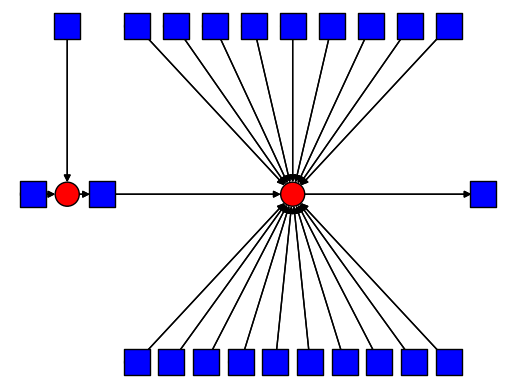

In [87]:
cpath = nx.dag_longest_path(G, weight='value')
nb_leaves, max_leaves, space_needed = prepare_caterpillar_tree(G, cpath)
caterpillar_montage = caterpillar_tree_in_graph(G, nb_leaves)
pos_for_caterpillar = position_of_caterpillar_tree(cpath, nb_leaves)
draw_caterpillar(caterpillar_montage, cpath, pos_for_caterpillar, with_edge_labels=False)

In [88]:
def critical_path_edges(G, weight='frequency_sum'):
    """Take a networkx graph G with a weight to provide
    a list of edge tuples identified as a critical path
    dag_longest_path provides node list in a DiGraph
    """
    path = nx.dag_longest_path(G, weight)
    path_edges = list(zip(path,path[1:]))
    return path_edges

cp_edges = critical_path_edges(e_G)

In [89]:
def fan_in_edges(G, edge_count=2):
    """Take a networkx graph G with a edge_count to provide
    a list of edge tuples identified as a fan-in task relation
    edge_count is threshold to return the list otherwise empty
    list returned"""
    
    fan_in_edges = []
    for n, attr in G.nodes(data=True):
        if  'ntype' in attr and attr['ntype'] == 'task':
            fan_in_nodes = [x for x in G.predecessors(n)]
#             print(n, len(fan_in_nodes))
            if len(fan_in_nodes) > edge_count:
                fan_in_edges += [(x, n) for x in fan_in_nodes]
    return fan_in_edges

def fan_out_edges(G, edge_count=2):
    fan_out_edges = []
    for n, attr in G.nodes(data=True):
        if  'ntype' in attr and attr['ntype'] == 'file':
            fan_out_nodes = [x for x in G.successors(n)]
            if len(fan_out_nodes) > edge_count:
                fan_out_edges += [(n, x) for x in fan_out_nodes]
    return fan_out_edges

fin_edges = fan_in_edges(G)
fout_edges = fan_out_edges(G)
# print(fin_edges)
# print(fout_edges)

In [90]:
def is_compressed_fan_in(G, fan_in_edges, threshold=.8):
    """Take a networkx graph G and list of edge tuples 
    to identify whether it is compressed or not based
    on a threshold number between outgoing volume size
    (sum of all edges) and incoming volume size (sum)"""
    incoming_vol_size=0
    outgoing_vol_size=0
    for u, v in fan_in_edges:
        attr = G.get_edge_data(u, v)
        if 'frequency_sum' in attr:
            incoming_vol_size += attr['frequency_sum']

    for n in G.successors(v):
        attr = G.get_edge_data(v, n)
        if 'frequency_sum' in attr:
            outgoing_vol_size += attr['frequency_sum']
        
    return (outgoing_vol_size/incoming_vol_size) <= threshold

is_compressed_fan_in(G, fin_edges)

True

In [91]:
def update_edge_multicolor(G, edge_tuples1, edge_tuples2, highlight_color1='purple', highlight_color2='green'):
    """Take a networkx graph G with a list of edge tuples 
    to change color of edges towards a sankey diagram"""
    color_list = []
    for u, v, attr in G.edges(data=True):
        is_matched1 = False
        is_matched2 = False
        for u1, v1 in edge_tuples1:
            if u == u1 and v == v1:
                is_matched1 = True
                break
        for u1, v1 in edge_tuples2:
            if u == u1 and v == v1:
                is_matched2 = True
                break
        if is_matched1 and is_matched2:
            color_list.append(highlight_color1)
        elif is_matched1 and not is_matched2:
            color_list.append(highlight_color1)
        elif not is_matched1 and is_matched2:
            color_list.append(highlight_color2)
        else:
            color_list.append('rgb(204,204,204)')
    return color_list
l_exp_pc['color'] = update_edge_multicolor(e_G, cp_edges, fin_edges, 'purple', 'orange')

In [92]:
# def update_edge_color(G, edge_tuples, highlight_color='purple'):
#     """Take a networkx graph G with a list of edge tuples 
#     to change color of edges towards a sankey diagram"""
#     color_list = []
#     for u, v, attr in G.edges(data=True):
#         is_matched = False
#         for u1, v1 in edge_tuples:
#             if u == u1 and v == v1:
#                 is_matched = True
#                 break
#         if is_matched:
#             color_list.append(highlight_color)
#         else:
#             color_list.append('rgb(204,204,204)')
#     return color_list

# l_exp_pc['color'] = update_edge_color(e_G, cp_edges, 'purple')

In [93]:
num_rows_to_select = len(df_e)
e_G = graph_by_table_with_top_x(G, df_e, f'access_size ({my_unit})', count=num_rows_to_select, ascending=False)
color_map_pc = {"task": "red",
                 "file": "blue",
                 "none": "grey"
                }
n_exp_pc, node_ref_exp_pc = get_nodes_for_sankey(e_G, color_map_pc)
# l_exp_pc = get_links_for_sankey(e_G, node_ref_exp_pc)
fig = go.Figure(go.Sankey(
            node = n_exp_pc,
            link = l_exp_pc, orientation='h', ))
#             textfont=dict(color="rgba(0,0,0,0)", size=1))) # remove it to add labels back
# fig.update_layout(dict1=dict(height=1024, width=2500), font_size=28)
fig.update_layout(dict1=dict(height=600, width=1000), font_size=10)
# fig.update_layout(dict1=dict(height=2324, width=5100), title_text="1000genome Sankey Diagram", font_size=20)
# fig.write_image("1000genome_workflow_all_edges.png")
fig.write_html("seismology_critical_path.html")
# fig.savefig("seismology_critical_path.pdf",bbox_inches = "tight")
fig.write_image("seismology_critical_path.pdf")

# printmd(f"<center> Fanout highlighted with green")
fig.show()